In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/openimages-1-91m-7x7-rgb-grayscale-pixel-patches/open_image_patch_pixels.csv


In [12]:
# Imports and config
import os
import gc
import json
import numpy as np
import pandas as pd
from typing import Tuple

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths
KAGGLE_CSV_PATH = "/kaggle/input/openimages-1-91m-7x7-rgb-grayscale-pixel-patches/open_image_patch_pixels.csv"
LOCAL_CSV_PATH = "/home/takrim/Desktop/AIProjects/AIResearch/openimage/open_image_patch_pixels.csv"
OUTPUT_DIR = os.path.join(os.getcwd(), "p25_rgb_from_grayscale_outputs_keras")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Device info
print("TF version:", tf.__version__)
print("Physical GPUs:", tf.config.list_physical_devices('GPU'))

# Training hyperparameters
BATCH_SIZE = 8192 if tf.config.list_physical_devices('GPU') else 2048
LR = 3e-4
MIN_LR = 1e-5
EPOCHS = 20
WEIGHT_DECAY = 1e-4  # L2 regularization strength for kernels
LUMA_LOSS_WEIGHT = 0.3  # weight for luminance consistency loss
GRAD_CLIP_NORM = 1.0

# Columns
P_COLS = [f"P{i}" for i in range(1, 50)]
R_COLS = [f"R{i}" for i in range(1, 50)]
G_COLS = [f"G{i}" for i in range(1, 50)]
B_COLS = [f"B{i}" for i in range(1, 50)]
TARGET_COLS = ["R25", "G25", "B25"]
USECOLS = P_COLS + TARGET_COLS

# Metrics helper
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    eps = 1e-8
    mae = np.mean(np.abs(y_true - y_pred), axis=0)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2, axis=0))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + eps)), axis=0)
    return {
        "mae_mean": float(mae.mean()),
        "rmse_mean": float(rmse.mean()),
        "mape_mean": float(mape.mean()),
        "mae": mae.tolist(),
        "rmse": rmse.tolist(),
        "mape": mape.tolist(),
    }


TF version: 2.18.0
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
# Data loading, preprocessing and split

# Choose source
csv_path = KAGGLE_CSV_PATH if os.path.exists(KAGGLE_CSV_PATH) else LOCAL_CSV_PATH
print(f"Reading from: {csv_path}")

# Read required columns; prefer header, fallback to explicit names if needed
dtype_map = {c: np.uint16 for c in USECOLS}


def read_dataframe(path: str, nrows: int | None = None) -> pd.DataFrame:
    try:
        df = pd.read_csv(path, usecols=USECOLS, dtype=dtype_map, nrows=nrows)
        if not set(USECOLS).issubset(df.columns):
            raise ValueError("Expected columns missing; re-reading with explicit names")
        return df
    except Exception:
        names = P_COLS + R_COLS + G_COLS + B_COLS
        df_full = pd.read_csv(path, header=None, names=names, dtype={c: np.uint16 for c in names}, nrows=nrows)
        return df_full[USECOLS]

# Load into memory and drop duplicates
df = read_dataframe(csv_path)
print(f"Loaded rows: {len(df)}")
df = df.drop_duplicates()
print(f"After drop_duplicates: {len(df)}")

# Preserve spatial order P1..P49
X_cols = P_COLS
Y_cols = TARGET_COLS

# Scale to [0,1]
X = df[X_cols].to_numpy(dtype=np.float32) / 255.0
Y = df[Y_cols].to_numpy(dtype=np.float32) / 255.0

# Train/val/test split
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=SEED)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=SEED)

print({
    "train": len(X_train),
    "val": len(X_val),
    "test": len(X_test),
})

del df
gc.collect()


Reading from: /kaggle/input/openimages-1-91m-7x7-rgb-grayscale-pixel-patches/open_image_patch_pixels.csv
Loaded rows: 1910098
After drop_duplicates: 1862192
{'train': 1489753, 'val': 186219, 'test': 186220}


6889

In [14]:
# Build tf.data pipelines

def make_dataset(X: np.ndarray, Y: np.ndarray, batch: int, shuffle: bool) -> tf.data.Dataset:
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(X), 1_000_000), seed=SEED)
    # map to image shape
    ds = ds.map(lambda x, y: (tf.reshape(x, (7, 7, 1)), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, Y_train, BATCH_SIZE, shuffle=True)
val_ds = make_dataset(X_val, Y_val, BATCH_SIZE, shuffle=False)
test_ds = make_dataset(X_test, Y_test, BATCH_SIZE, shuffle=False)



In [16]:
# Define deeper Keras CNN with residual blocks, BN, L2, and luminance consistency

def residual_block(x, filters: int, kernel_size: int = 3, name: str | None = None):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(WEIGHT_DECAY), name=None if not name else name+"_conv1")(x)
    x = layers.BatchNormalization(name=None if not name else name+"_bn1")(x)
    x = layers.Activation("relu", name=None if not name else name+"_relu1")(x)
    x = layers.Conv2D(filters, kernel_size, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(WEIGHT_DECAY), name=None if not name else name+"_conv2")(x)
    x = layers.BatchNormalization(name=None if not name else name+"_bn2")(x)
    x = layers.Add(name=None if not name else name+"_add")([x, shortcut])
    x = layers.Activation("relu", name=None if not name else name+"_out")(x)
    return x


# Compatibility: register custom layer if API available; otherwise no-op
try:
    register_keras_serializable = keras.utils.register_keras_serializable
except Exception:
    try:
        from tensorflow.keras.utils import register_keras_serializable  # older TF Keras
    except Exception:
        def register_keras_serializable(*args, **kwargs):
            def deco(cls):
                return cls
            return deco


@register_keras_serializable()
class LumaLossLayer(layers.Layer):
    def __init__(self, weight: float, **kwargs):
        super().__init__(**kwargs)
        self.weight = weight

    def get_config(self):
        config = super().get_config()
        config.update({"weight": float(self.weight)})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, inputs):
        y, patch = inputs  # y: (B,3); patch: (B,7,7,1)
        luma = 0.299 * y[:, 0] + 0.587 * y[:, 1] + 0.114 * y[:, 2]
        p25 = patch[:, 3, 3, 0]
        diff = keras.ops.abs(luma - p25)
        loss = self.weight * keras.ops.mean(diff)
        self.add_loss(loss)
        return y


def build_model() -> keras.Model:
    inputs = keras.Input(shape=(7, 7, 1), name="patch")
    # Stem
    x = layers.Conv2D(32, 3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Residual stack
    x = residual_block(x, 32, name="res1")
    x = residual_block(x, 32, name="res2")
    x = residual_block(x, 32, name="res3")

    # Head
    x = layers.Conv2D(64, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    outputs = layers.Dense(3, activation="sigmoid", name="rgb25")(x)

    # Inject luminance consistency loss via custom layer (returns y unchanged)
    outputs = LumaLossLayer(LUMA_LOSS_WEIGHT, name="luma_consistency")([outputs, inputs])

    model = keras.Model(inputs, outputs)
    return model

model = build_model()

# Optimizer with LR schedule and grad clipping
steps_per_epoch = max(1, len(X_train) // BATCH_SIZE)
cosine_schedule = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=LR, first_decay_steps=steps_per_epoch * 5, t_mul=2.0, m_mul=0.9, alpha=MIN_LR / LR
)
optimizer = keras.optimizers.Adam(learning_rate=LR, clipnorm=GRAD_CLIP_NORM)

model.compile(optimizer=optimizer, loss="mae", metrics=[keras.metrics.MeanAbsoluteError(name="mae")])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ patch (InputLayer)  │ (None, 7, 7, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 32)  │        288 │ patch[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 32)  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 7, 7, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_conv1 (Conv2D) │ (None, 7, 7, 32)  │      9,216 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_bn1            │ (None, 7, 7, 32)  │        128 │ res1_conv1[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_relu1          │ (None, 7, 7, 32)  │          0 │ res1_bn1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_conv2 (Conv2D) │ (None, 7, 7, 32)  │      9,216 │ res1_relu1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_bn2            │ (None, 7, 7, 32)  │        128 │ res1_conv2[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_add (Add)      │ (None, 7, 7, 32)  │          0 │ res1_bn2[0][0],   │
│                     │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_out            │ (None, 7, 7, 32)  │          0 │ res1_add[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_conv1 (Conv2D) │ (None, 7, 7, 32)  │      9,216 │ res1_out[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_bn1            │ (None, 7, 7, 32)  │        128 │ res2_conv1[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_relu1          │ (None, 7, 7, 32)  │          0 │ res2_bn1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_conv2 (Conv2D) │ (None, 7, 7, 32)  │      9,216 │ res2_relu1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_bn2            │ (None, 7, 7, 32)  │        128 │ res2_conv2[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_add (Add)      │ (None, 7, 7, 32)  │          0 │ res2_bn2[0][0],   │
│                     │                   │            │ res1_out[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_out            │ (None, 7, 7, 32)  │          0 │ res2_add[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res3_conv1 (Conv2D) │ (None, 7, 7, 32)  │      9,216 │ res2_out[0][0]  

 Total params: 911,331 (3.48 MB)

 Trainable params: 910,883 (3.47 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 44s 168ms/step - loss: 0.1681 - mae: 0.0779 - val_loss: 0.3512 - val_mae: 0.2248 - learning_rate: 3.0000e-04
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - loss: 0.1203 - mae: 0.0562 - val_loss: 0.2664 - val_mae: 0.1673 - learning_rate: 2.7231e-04
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - loss: 0.1111 - mae: 0.0551 - val_loss: 0.1613 - val_mae: 0.0918 - learning_rate: 1.9981e-04
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - loss: 0.1059 - mae: 0.0544 - val_loss: 0.1081 - val_mae: 0.0568 - learning_rate: 1.1019e-04
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - loss: 0.1033 - mae: 0.0540 - val_loss: 0.1043 - val_mae: 0.0548 - learning_rate: 3.7693e-05
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 0.1031 - mae: 0.0549 - val_loss: 0.0981 - val_mae: 0.0543 - learning_rate: 3.0000e-04
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 131ms/step - loss: 0.0970 - mae: 0.0543 - val_loss: 0.0943 - v

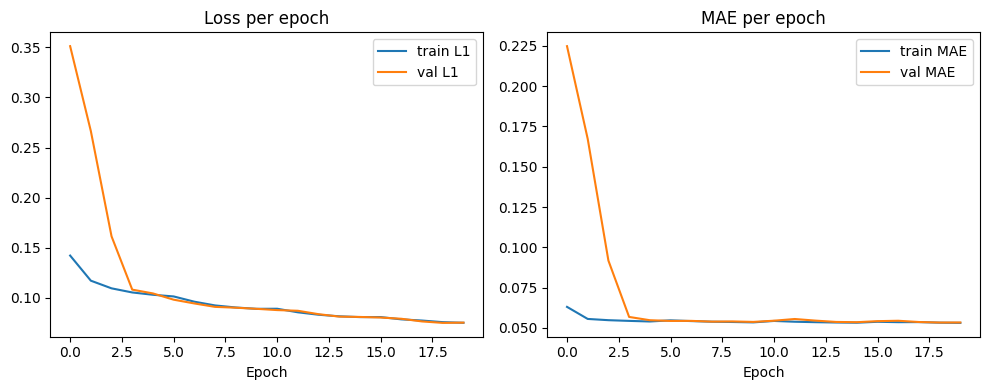

In [17]:
# Train with per-epoch metrics and plots

# Ensure datasets and helpers exist if this cell is run before earlier cells
try:
    make_dataset  # type: ignore # noqa: F821
except NameError:
    def make_dataset(X: np.ndarray, Y: np.ndarray, batch: int, shuffle: bool) -> tf.data.Dataset:
        ds = tf.data.Dataset.from_tensor_slices((X, Y))
        if shuffle:
            ds = ds.shuffle(buffer_size=min(len(X), 1_000_000), seed=SEED)
        ds = ds.map(lambda x, y: (tf.reshape(x, (7, 7, 1)), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
        return ds

try:
    train_ds
    val_ds
except NameError:
    train_ds = make_dataset(X_train, Y_train, BATCH_SIZE, shuffle=True)
    val_ds = make_dataset(X_val, Y_val, BATCH_SIZE, shuffle=False)
    test_ds = make_dataset(X_test, Y_test, BATCH_SIZE, shuffle=False)

def cosine_lr(epoch, lr):
    # Cosine with restarts based on epochs; simple per-epoch scheduler
    cycle = 5
    e = epoch % cycle
    cos_inner = (np.pi * e) / cycle
    new_lr = MIN_LR + 0.5 * (LR - MIN_LR) * (1 + np.cos(cos_inner))
    return float(new_lr)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(OUTPUT_DIR, "best_model.keras"),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.LearningRateScheduler(cosine_lr, verbose=0),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train L1")
plt.plot(history.history["val_loss"], label="val L1")
plt.title("Loss per epoch")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history.get("mae", []), label="train MAE")
plt.plot(history.history.get("val_mae", []), label="val MAE")
plt.title("MAE per epoch")
plt.xlabel("Epoch")
plt.legend()
plt.tight_layout()
plt.show()



Test metrics: {
  "mae_mean": 0.053255368024110794,
  "rmse_mean": 0.08403883129358292,
  "mape_mean": 83205.09375,
  "mae": [
    0.0577591136097908,
    0.02235681191086769,
    0.07965017110109329
  ],
  "rmse": [
    0.09285300225019455,
    0.03829239308834076,
    0.12097112089395523
  ],
  "mape": [
    56470.57421875,
    24283.357421875,
    168861.34375
  ]
}


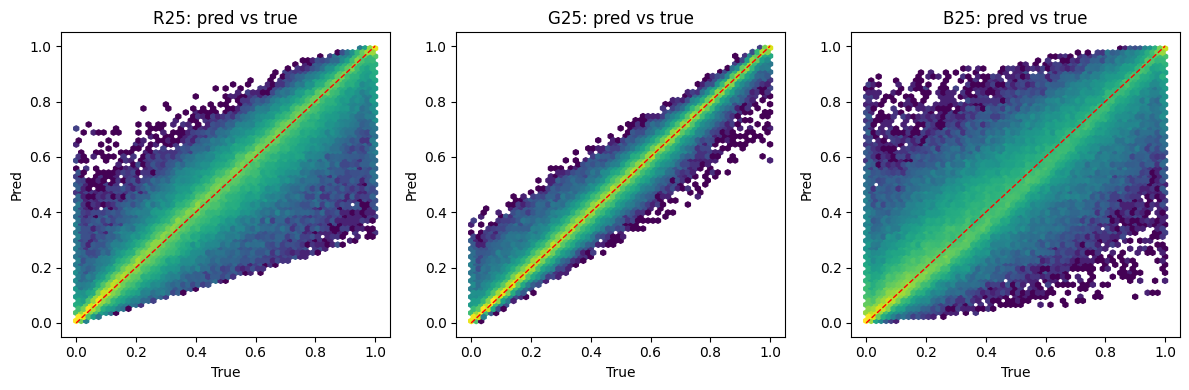

Saved artifact at '/kaggle/working/p25_rgb_from_grayscale_outputs_keras/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7, 7, 1), dtype=tf.float32, name='patch')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138140072166608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138140381455056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138140381451792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138140072165456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138140072168720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138140381458512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138140381458704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138140381456592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138140381459088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138140381456784: TensorSpec(shape=(), dtype=tf.

W0000 00:00:1755449876.363067      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1755449876.363101      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1755449876.382905      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [19]:
# Evaluate on test, visualize, and save artifacts

# Load best model
best_model_path = os.path.join(OUTPUT_DIR, "best_model.keras")
best_model = keras.models.load_model(best_model_path, custom_objects={"LumaLossLayer": LumaLossLayer})

# Predict on test
y_true_batches = []
y_pred_batches = []
for xb, yb in test_ds:
    y_pred_batches.append(best_model.predict(xb, verbose=0))
    y_true_batches.append(yb.numpy())

y_true = np.concatenate(y_true_batches, axis=0)
y_pred = np.concatenate(y_pred_batches, axis=0)

metrics = compute_metrics(y_true, y_pred)
print("Test metrics:", json.dumps(metrics, indent=2))

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
labels = ["R25", "G25", "B25"]
for i, ax in enumerate(axes):
    ax.hexbin(y_true[:, i], y_pred[:, i], gridsize=60, cmap="viridis", bins="log")
    ax.plot([0, 1], [0, 1], "r--", lw=1)
    ax.set_title(f"{labels[i]}: pred vs true")
    ax.set_xlabel("True")
    ax.set_ylabel("Pred")
plt.tight_layout()
plt.show()

# Save artifacts
np.save(os.path.join(OUTPUT_DIR, "y_true_test.npy"), y_true)
np.save(os.path.join(OUTPUT_DIR, "y_pred_test.npy"), y_pred)
with open(os.path.join(OUTPUT_DIR, "test_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Save SavedModel and TFLite
saved_model_dir = os.path.join(OUTPUT_DIR, "saved_model")
# In Keras 3+, use export() to write a TensorFlow SavedModel
best_model.export(saved_model_dir)
print(f"SavedModel exported to: {saved_model_dir}")

# TFLite conversion
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
with open(os.path.join(OUTPUT_DIR, "model.tflite"), "wb") as f:
    f.write(tflite_model)
print("TFLite model saved.")


In [20]:
# Inference helper for a single 7x7 grayscale patch (values in [0,255])

def predict_r25_g25_b25_keras(patch_p: np.ndarray) -> np.ndarray:
    assert patch_p.shape == (7, 7)
    x = (patch_p.astype(np.float32) / 255.0)[None, :, :, None]
    y = best_model.predict(x, verbose=0)[0]
    return np.clip(np.round(y * 255.0), 0, 255).astype(np.uint8)
